# Crime Incidents Time Series Forecasting
*Requirement: FORECAST-01*

**Objective:** Forecast daily crime incidents for the next 60 days using Prophet with 95% confidence intervals and anomaly detection.

**Key Outputs:**
- 60-day forecast with prediction intervals
- Anomaly detection thresholds
- Model performance metrics
- Operational recommendations

In [1]:
# Reproducibility parameters
VERSION = "v1.0"
FORECAST_HORIZON_DAYS = 60
VALIDATION_DAYS = 30
RANDOM_SEED = 42
CONFIDENCE_INTERVAL = 0.95

In [2]:
import time
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')

# Robust repo_root detection
cwd = Path.cwd()
if (cwd / 'config' / 'phase1_config.yaml').exists():
    repo_root = cwd
elif (cwd.parent / 'config' / 'phase1_config.yaml').exists():
    repo_root = cwd.parent
else:
    raise RuntimeError(f"Cannot find config from cwd={cwd}")

sys.path.insert(0, str(repo_root))
print(f"Repository root: {repo_root}")

# Define paths
DATA_DIR = repo_root / 'data'
REPORTS_DIR = repo_root / 'reports'
REPORTS_DIR.mkdir(exist_ok=True)

# Record execution metadata
start_time = time.time()
run_timestamp = time.strftime('%Y%m%d_%H%M%S')
print(f"\nExecution started: {run_timestamp}")
print(f"Version: {VERSION}")
print(f"Forecast horizon: {FORECAST_HORIZON_DAYS} days")
print(f"Confidence interval: {CONFIDENCE_INTERVAL*100}%")
print(f"Random seed: {RANDOM_SEED}")

Repository root: /Users/dustinober/Projects/Crime Incidents Philadelphia

Execution started: 20260203_065515
Version: v1.0
Forecast horizon: 60 days
Confidence interval: 95.0%
Random seed: 42


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from datetime import datetime, timedelta

# Import custom utilities
from analysis.models.time_series import (
    prepare_prophet_data,
    create_train_test_split,
    get_prophet_config,
    evaluate_forecast,
    detect_anomalies
)

# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)

# Configure plotting
sns.set_style('darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Data Loading and Preparation

Load crime incidents and aggregate by date to create daily time series.

In [4]:
# Load crime incidents
crime_file = DATA_DIR / 'crime_incidents_combined.parquet'
print(f"Loading data from: {crime_file}")
df_raw = pd.read_parquet(crime_file)

# Convert categorical dispatch_date to datetime for aggregation
df_raw['dispatch_date'] = pd.to_datetime(df_raw['dispatch_date'].astype(str))

print(f"\nRaw data shape: {df_raw.shape}")
print(f"Date range: {df_raw['dispatch_date'].min().date()} to {df_raw['dispatch_date'].max().date()}")
print(f"Total incidents: {len(df_raw):,}")

Loading data from: /Users/dustinober/Projects/Crime Incidents Philadelphia/data/crime_incidents_combined.parquet



Raw data shape: (3496353, 16)
Date range: 2006-01-01 to 2026-01-20
Total incidents: 3,496,353


In [5]:
# Aggregate incidents by date
df_daily = df_raw.groupby('dispatch_date').size().reset_index(name='incident_count')
df_daily.columns = ['date', 'count']
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily = df_daily.sort_values('date').reset_index(drop=True)

print(f"\nDaily aggregation complete")
print(f"Time series length: {len(df_daily)} days")
print(f"Date range: {df_daily['date'].min().date()} to {df_daily['date'].max().date()}")
print(f"\nDaily incident statistics:")
print(df_daily['count'].describe())


Daily aggregation complete
Time series length: 7324 days
Date range: 2006-01-01 to 2026-01-20

Daily incident statistics:
count    7324.000000
mean      477.382987
std        97.983612
min        61.000000
25%       410.000000
50%       477.000000
75%       543.000000
max       855.000000
Name: count, dtype: float64


In [6]:
# Prepare data in Prophet format (ds, y)
df_prophet = prepare_prophet_data(df_daily, 'date', 'count')

print("\nProphet format data:")
print(df_prophet.head())
print(f"\nShape: {df_prophet.shape}")
print(f"Missing values: {df_prophet.isnull().sum().sum()}")


Prophet format data:
          ds    y
0 2006-01-01  583
1 2006-01-02  550
2 2006-01-03  596
3 2006-01-04  662
4 2006-01-05  552

Shape: (7324, 2)
Missing values: 0


## 2. Exploratory Time Series Visualization

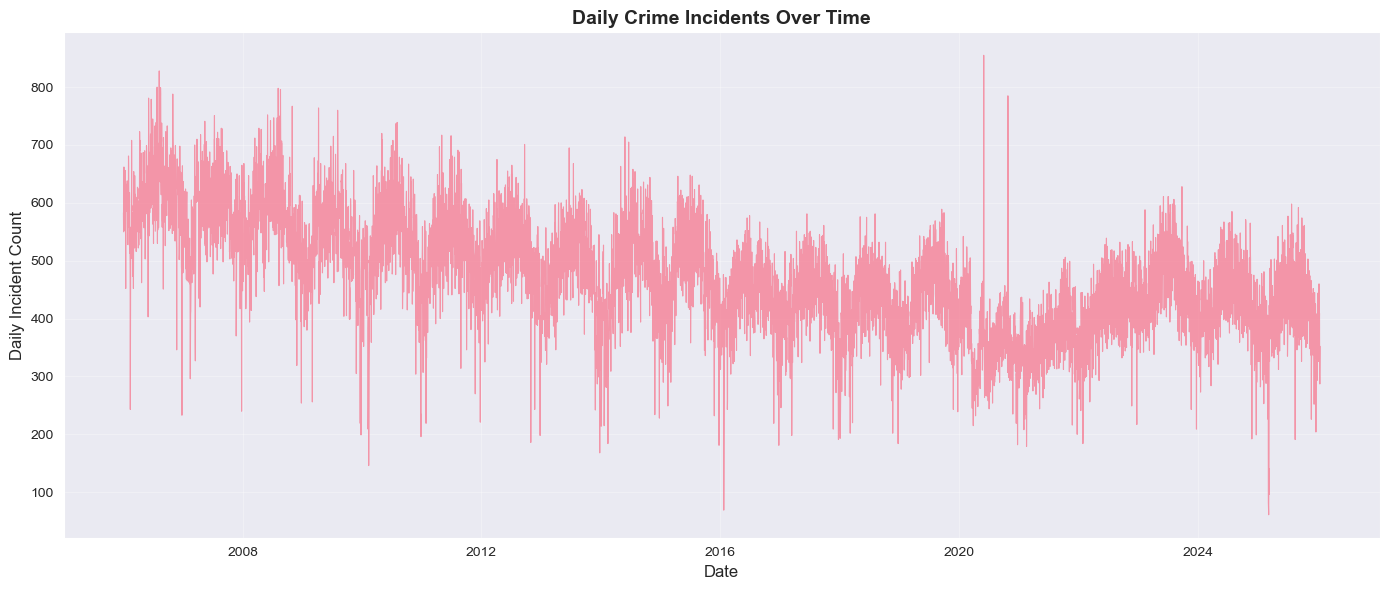

Time series visualization saved to reports/


In [7]:
# Plot full time series
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df_prophet['ds'], df_prophet['y'], linewidth=0.8, alpha=0.7)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Daily Incident Count', fontsize=12)
ax.set_title('Daily Crime Incidents Over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'forecast_timeseries_raw.png', dpi=300, bbox_inches='tight')
plt.show()

print("Time series visualization saved to reports/")

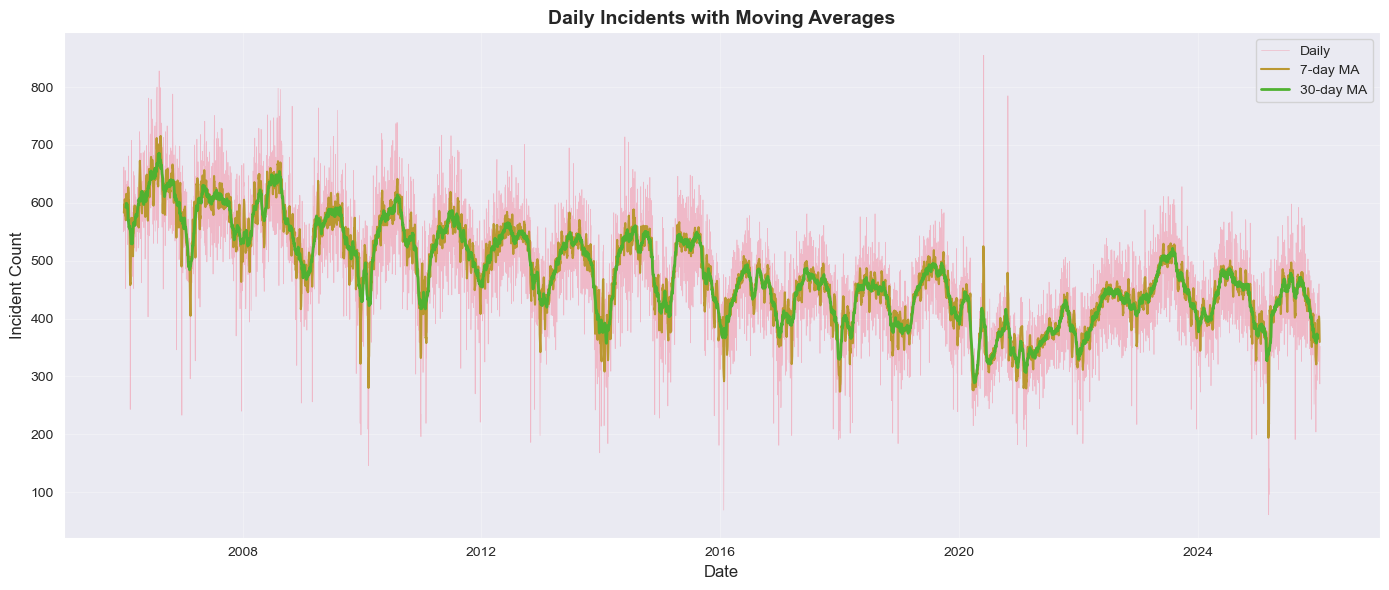

In [8]:
# Calculate rolling statistics
df_prophet['rolling_mean_7'] = df_prophet['y'].rolling(window=7, center=True).mean()
df_prophet['rolling_mean_30'] = df_prophet['y'].rolling(window=30, center=True).mean()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df_prophet['ds'], df_prophet['y'], linewidth=0.5, alpha=0.4, label='Daily')
ax.plot(df_prophet['ds'], df_prophet['rolling_mean_7'], linewidth=1.5, label='7-day MA')
ax.plot(df_prophet['ds'], df_prophet['rolling_mean_30'], linewidth=2, label='30-day MA')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Incident Count', fontsize=12)
ax.set_title('Daily Incidents with Moving Averages', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'forecast_timeseries_smoothed.png', dpi=300, bbox_inches='tight')
plt.show()

# Clean up rolling stats columns for Prophet
df_prophet = df_prophet[['ds', 'y']].copy()

## 3. Train/Validation Split

Create temporal split for model validation before generating future forecast.

In [9]:
# Create train/validation split
train_df, validation_df = create_train_test_split(df_prophet, test_days=VALIDATION_DAYS)

print(f"Train set: {len(train_df)} days ({train_df['ds'].min().date()} to {train_df['ds'].max().date()})")
print(f"Validation set: {len(validation_df)} days ({validation_df['ds'].min().date()} to {validation_df['ds'].max().date()})")
print(f"\nTrain set statistics:")
print(train_df['y'].describe())

Train set: 7294 days (2006-01-01 to 2025-12-21)
Validation set: 30 days (2025-12-22 to 2026-01-20)

Train set statistics:
count    7294.000000
mean      477.840143
std        97.843940
min        61.000000
25%       410.000000
50%       477.000000
75%       544.000000
max       855.000000
Name: y, dtype: float64


## 4. Prophet Model Training

Train Prophet model on historical data with appropriate seasonality settings for crime data.

In [10]:
# Get Prophet configuration for crime forecasting
prophet_config = get_prophet_config(
    seasonality_mode='multiplicative',  # Crime patterns scale with overall level
    yearly=True,                         # Capture annual seasonality
    weekly=True,                         # Capture day-of-week patterns
    daily=False,                         # Daily data, no intraday patterns
    changepoint_prior_scale=0.05,       # Moderate flexibility for trend changes
    interval_width=CONFIDENCE_INTERVAL  # 95% prediction intervals
)

print("Prophet Configuration:")
for key, value in prophet_config.items():
    print(f"  {key}: {value}")

Prophet Configuration:
  seasonality_mode: multiplicative
  yearly_seasonality: True
  weekly_seasonality: True
  daily_seasonality: False
  changepoint_prior_scale: 0.05
  interval_width: 0.95


In [11]:
# Initialize and train Prophet model on training data
print("Training Prophet model...")
model = Prophet(**prophet_config)

# Fit model on training set
model.fit(train_df)

print(f"✓ Model trained on {len(train_df)} days")
print(f"  Date range: {train_df['ds'].min().date()} to {train_df['ds'].max().date()}")

Training Prophet model...


06:55:19 - cmdstanpy - INFO - Chain [1] start processing


06:55:20 - cmdstanpy - INFO - Chain [1] done processing


✓ Model trained on 7294 days
  Date range: 2006-01-01 to 2025-12-21


In [12]:
# Generate predictions on validation set
validation_forecast = model.predict(validation_df[['ds']])

# Evaluate model performance on validation set (use .values to avoid index mismatch)
val_metrics = evaluate_forecast(
    actual=validation_df['y'].values,
    predicted=validation_forecast['yhat'].values,
    lower=validation_forecast['yhat_lower'].values,
    upper=validation_forecast['yhat_upper'].values
)

print("\nValidation Set Performance:")
print(f"  MAE: {val_metrics['mae']:.2f} incidents/day")
print(f"  RMSE: {val_metrics['rmse']:.2f} incidents/day")
print(f"  MAPE: {val_metrics['mape']:.2f}%")
print(f"  R²: {val_metrics['r2']:.4f}")
print(f"  95% CI Coverage: {val_metrics['coverage']*100:.1f}%")


Validation Set Performance:
  MAE: 43.92 incidents/day
  RMSE: 59.60 incidents/day
  MAPE: 14.15%
  R²: 0.0760
  95% CI Coverage: 96.7%


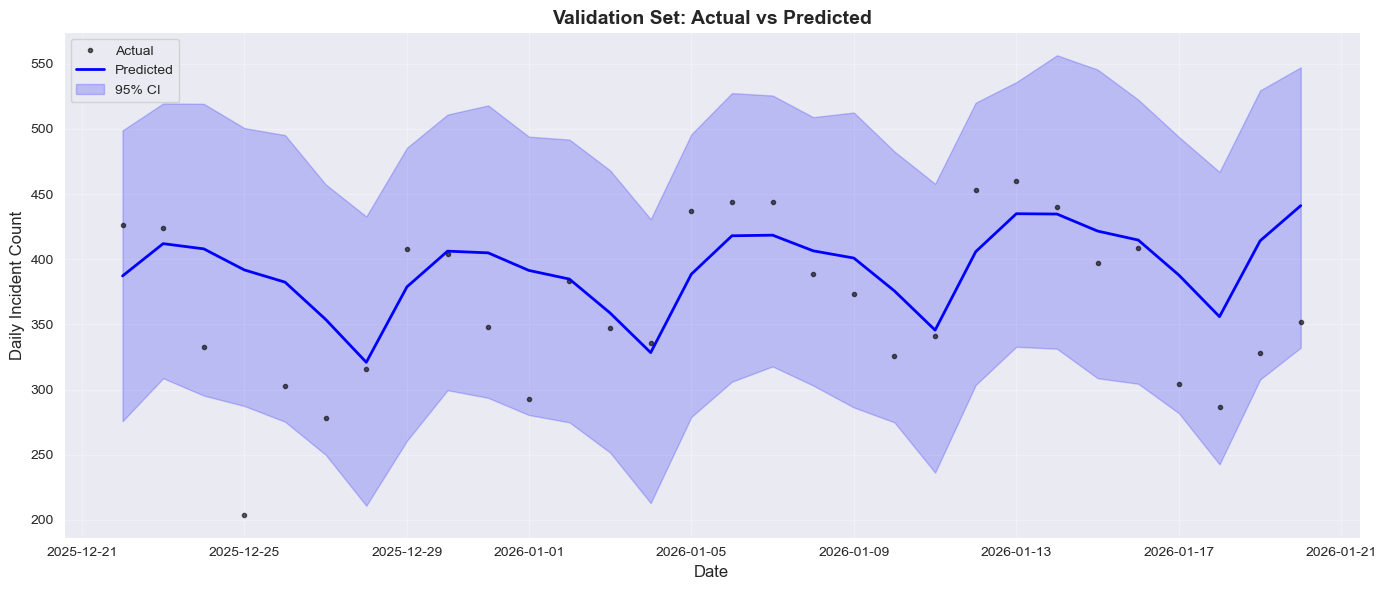

In [13]:
# Plot validation results
fig, ax = plt.subplots(figsize=(14, 6))

# Plot actual values
ax.plot(validation_df['ds'], validation_df['y'], 
        'o', markersize=3, label='Actual', alpha=0.6, color='black')

# Plot predictions
ax.plot(validation_forecast['ds'], validation_forecast['yhat'], 
        '-', linewidth=2, label='Predicted', color='blue')

# Plot confidence intervals
ax.fill_between(validation_forecast['ds'],
                validation_forecast['yhat_lower'],
                validation_forecast['yhat_upper'],
                alpha=0.2, color='blue', label='95% CI')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Daily Incident Count', fontsize=12)
ax.set_title('Validation Set: Actual vs Predicted', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'forecast_validation.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Generate Future Forecast

Retrain on all available data and generate 60-day future forecast.

In [14]:
# Train final model on ALL data for future forecasting
print("Training final model on all available data...")
final_model = Prophet(**prophet_config)
final_model.fit(df_prophet)

print(f"✓ Final model trained on {len(df_prophet)} days")
print(f"  Date range: {df_prophet['ds'].min().date()} to {df_prophet['ds'].max().date()}")

06:55:21 - cmdstanpy - INFO - Chain [1] start processing


Training final model on all available data...


06:55:21 - cmdstanpy - INFO - Chain [1] done processing


✓ Final model trained on 7324 days
  Date range: 2006-01-01 to 2026-01-20


In [15]:
# Create future dataframe for 60-day forecast
future = final_model.make_future_dataframe(periods=FORECAST_HORIZON_DAYS, freq='D')

print(f"\nGenerating {FORECAST_HORIZON_DAYS}-day forecast...")
forecast = final_model.predict(future)

# Extract forecast period only
forecast_future = forecast[forecast['ds'] > df_prophet['ds'].max()].copy()

print(f"✓ Forecast generated")
print(f"  Forecast period: {forecast_future['ds'].min().date()} to {forecast_future['ds'].max().date()}")
print(f"  Forecast days: {len(forecast_future)}")
print(f"\nForecast Summary:")
print(f"  Mean predicted incidents/day: {forecast_future['yhat'].mean():.1f}")
print(f"  Range: {forecast_future['yhat'].min():.1f} to {forecast_future['yhat'].max():.1f}")
print(f"  Lower bound (95% CI): {forecast_future['yhat_lower'].mean():.1f}")
print(f"  Upper bound (95% CI): {forecast_future['yhat_upper'].mean():.1f}")


Generating 60-day forecast...


✓ Forecast generated
  Forecast period: 2026-01-21 to 2026-03-21
  Forecast days: 60

Forecast Summary:
  Mean predicted incidents/day: 403.0
  Range: 330.1 to 449.7
  Lower bound (95% CI): 293.9
  Upper bound (95% CI): 511.2


In [16]:
# Capture execution metadata
metadata = {
    'version': VERSION,
    'execution_timestamp': run_timestamp,
    'forecast_horizon_days': FORECAST_HORIZON_DAYS,
    'validation_days': VALIDATION_DAYS,
    'confidence_interval': CONFIDENCE_INTERVAL,
    'random_seed': RANDOM_SEED,
    'data_source': str(crime_file),
    'total_observations': len(df_prophet),
    'train_observations': len(train_df),
    'validation_observations': len(validation_df),
    'date_range_start': str(df_prophet['ds'].min().date()),
    'date_range_end': str(df_prophet['ds'].max().date()),
    'mean_daily_incidents': float(df_prophet['y'].mean()),
    'std_daily_incidents': float(df_prophet['y'].std())
}

print("\nExecution metadata captured")


Execution metadata captured


## 6. Anomaly Detection

Define anomaly detection thresholds based on prediction intervals and identify unusual periods.

In [17]:
# Generate forecast for historical period to detect anomalies
historical_forecast = final_model.predict(df_prophet[['ds']])

# Merge actual values with forecast
anomaly_df = df_prophet.merge(
    historical_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds'
)

# Detect anomalies
anomaly_df['is_anomaly'] = detect_anomalies(
    anomaly_df,
    actual_col='y',
    predicted_col='yhat',
    lower_col='yhat_lower',
    upper_col='yhat_upper',
    threshold_std=2.0
)

# Summary statistics
n_anomalies = anomaly_df['is_anomaly'].sum()
anomaly_rate = (n_anomalies / len(anomaly_df)) * 100

print(f"\nAnomaly Detection Results:")
print(f"  Total anomalies detected: {n_anomalies} days ({anomaly_rate:.2f}%)")
print(f"  Expected anomaly rate (outside 95% CI): ~5%")

# Show most extreme anomalies
anomaly_df['residual'] = anomaly_df['y'] - anomaly_df['yhat']
top_anomalies = anomaly_df[anomaly_df['is_anomaly']].nlargest(10, 'residual')[['ds', 'y', 'yhat', 'residual']]
print(f"\nTop 10 positive anomalies (higher than expected):")
for idx, row in top_anomalies.iterrows():
    print(f"  {row['ds'].date()}: {row['y']:.0f} incidents (expected {row['yhat']:.0f}, +{row['residual']:.0f})")


Anomaly Detection Results:
  Total anomalies detected: 383 days (5.23%)
  Expected anomaly rate (outside 95% CI): ~5%

Top 10 positive anomalies (higher than expected):
  2020-06-01: 855 incidents (expected 410, +445)
  2020-10-27: 785 incidents (expected 397, +388)
  2020-05-31: 622 incidents (expected 360, +262)
  2020-10-28: 618 incidents (expected 395, +223)
  2023-02-13: 588 incidents (expected 374, +214)
  2008-06-01: 752 incidents (expected 542, +210)
  2008-03-15: 712 incidents (expected 511, +201)
  2006-06-04: 781 incidents (expected 584, +197)
  2010-05-01: 720 incidents (expected 525, +195)
  2009-04-09: 764 incidents (expected 573, +191)


In [18]:
# Define operational anomaly detection thresholds
threshold_definitions = {
    'Level 1 - Information': {
        'description': 'Incident count above 95% upper bound',
        'threshold': 'yhat_upper',
        'action': 'Monitor - no immediate action required'
    },
    'Level 2 - Alert': {
        'description': 'Incident count > 10% above upper bound',
        'threshold': 'yhat_upper * 1.10',
        'action': 'Review resource allocation for affected areas'
    },
    'Level 3 - Critical': {
        'description': 'Incident count > 20% above upper bound',
        'threshold': 'yhat_upper * 1.20',
        'action': 'Immediate operational response - investigate root cause'
    }
}

print("\nOperational Anomaly Detection Thresholds:")
print("="*70)
for level, details in threshold_definitions.items():
    print(f"\n{level}:")
    print(f"  Definition: {details['description']}")
    print(f"  Threshold: {details['threshold']}")
    print(f"  Action: {details['action']}")


Operational Anomaly Detection Thresholds:

Level 1 - Information:
  Definition: Incident count above 95% upper bound
  Threshold: yhat_upper
  Action: Monitor - no immediate action required

Level 2 - Alert:
  Definition: Incident count > 10% above upper bound
  Threshold: yhat_upper * 1.10
  Action: Review resource allocation for affected areas

Level 3 - Critical:
  Definition: Incident count > 20% above upper bound
  Threshold: yhat_upper * 1.20
  Action: Immediate operational response - investigate root cause


## 7. Final Forecast Visualization

Create comprehensive visualization showing historical data, forecast, and confidence intervals.

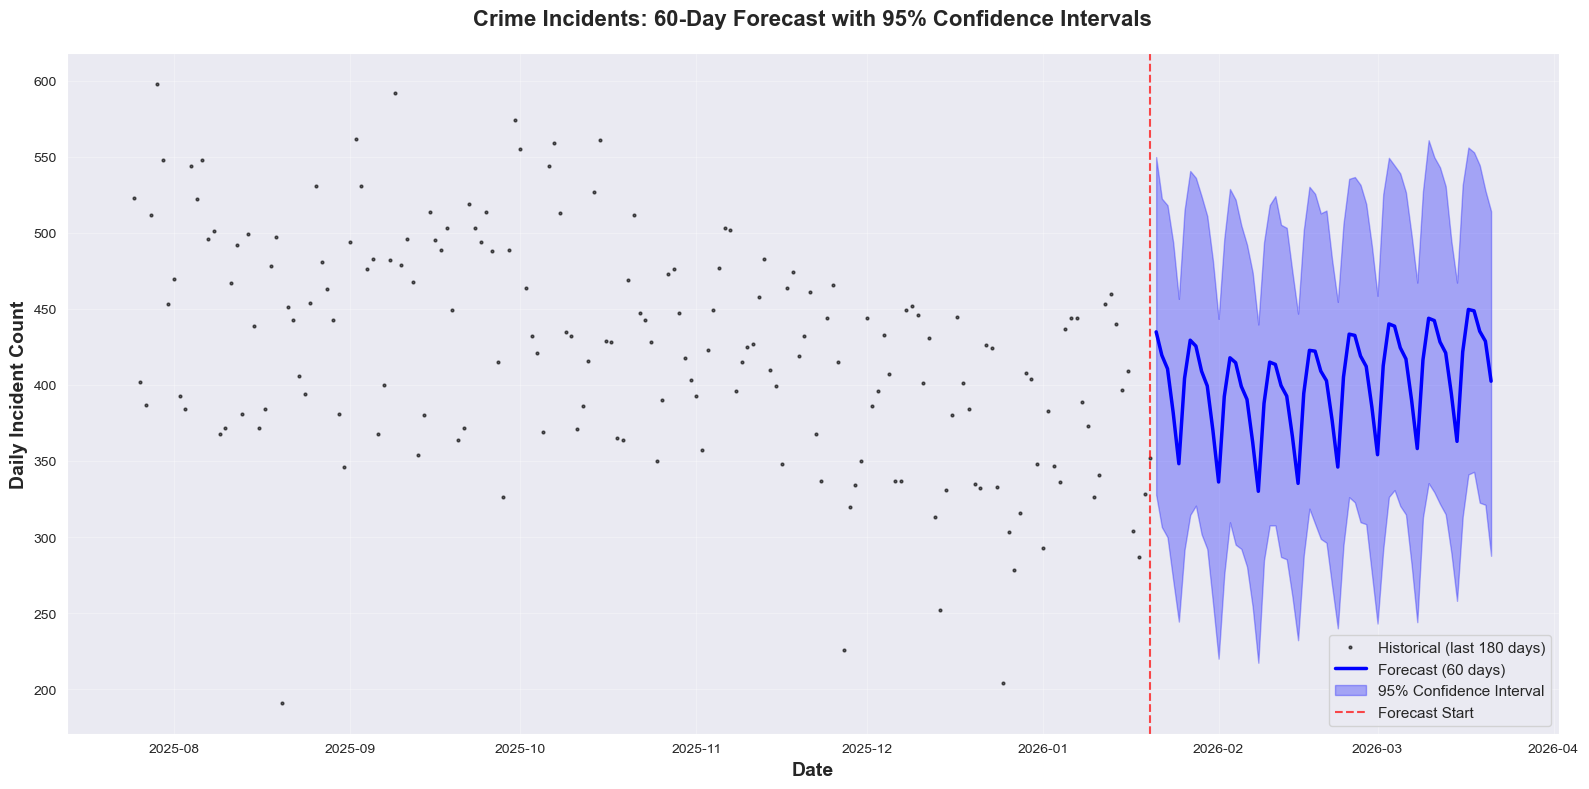


✓ Final forecast visualization saved to reports/forecast_60day_final.png


In [19]:
# Create comprehensive forecast plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot last 180 days of historical data
recent_days = 180
df_recent = df_prophet.tail(recent_days)
ax.plot(df_recent['ds'], df_recent['y'], 
        'o', markersize=2, label='Historical (last 180 days)', alpha=0.6, color='black')

# Plot forecast period
ax.plot(forecast_future['ds'], forecast_future['yhat'], 
        '-', linewidth=2.5, label='Forecast (60 days)', color='blue')

# Plot 95% confidence intervals
ax.fill_between(forecast_future['ds'],
                forecast_future['yhat_lower'],
                forecast_future['yhat_upper'],
                alpha=0.3, color='blue', label='95% Confidence Interval')

# Add vertical line at forecast start
forecast_start = df_prophet['ds'].max()
ax.axvline(forecast_start, color='red', linestyle='--', linewidth=1.5, 
           label='Forecast Start', alpha=0.7)

ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Daily Incident Count', fontsize=14, fontweight='bold')
ax.set_title('Crime Incidents: 60-Day Forecast with 95% Confidence Intervals',
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'forecast_60day_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Final forecast visualization saved to reports/forecast_60day_final.png")

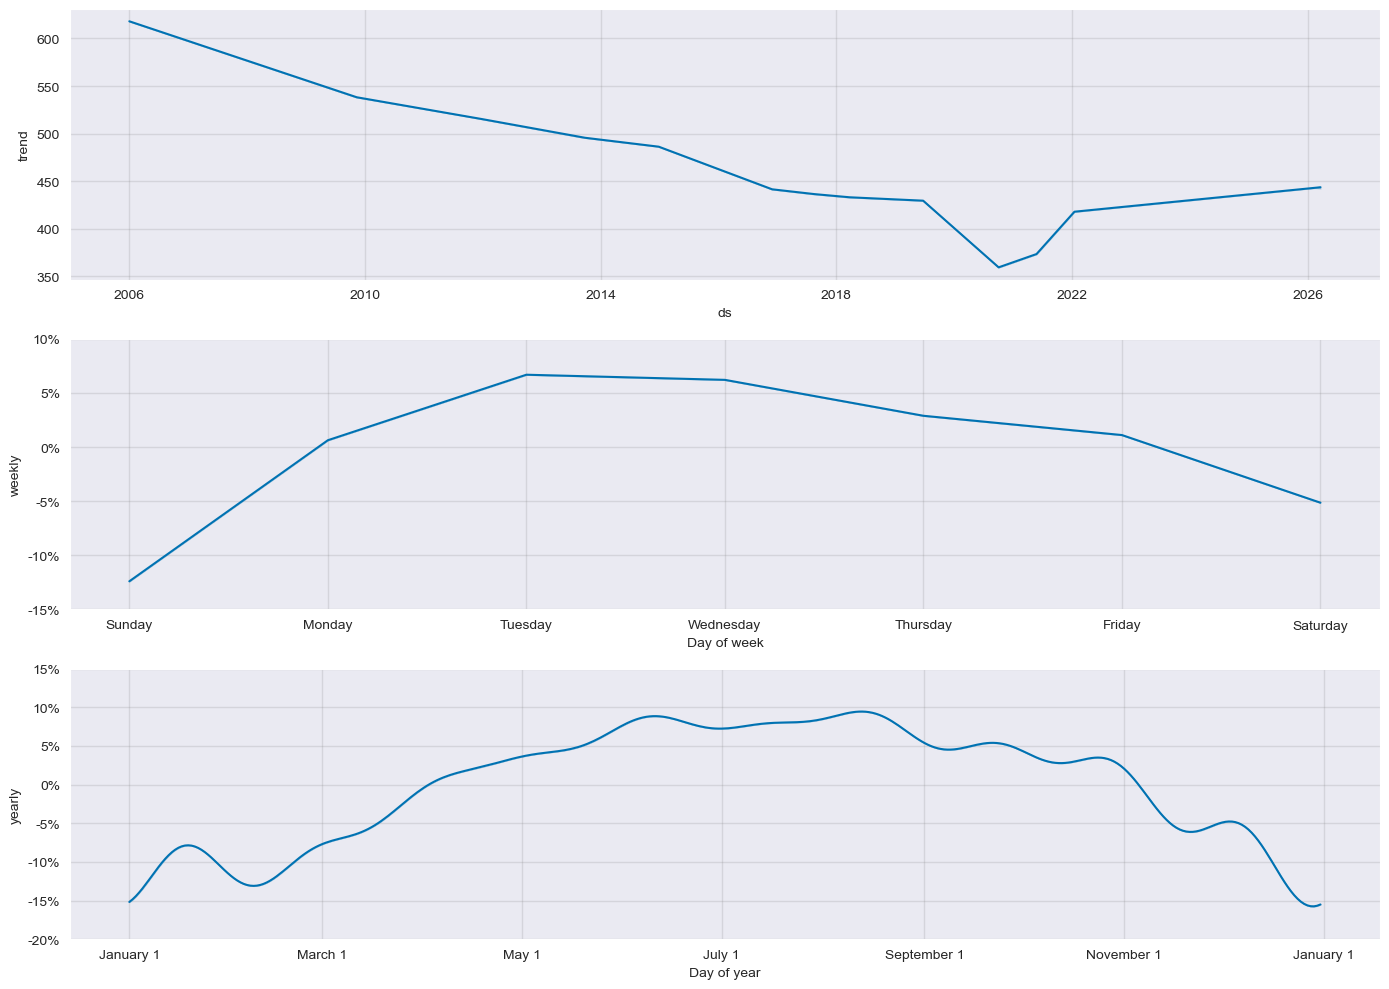

✓ Forecast components visualization saved to reports/forecast_components.png


In [20]:
# Plot forecast components (trend and seasonality)
fig = final_model.plot_components(forecast, figsize=(14, 10))
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'forecast_components.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Forecast components visualization saved to reports/forecast_components.png")

## 8. Summary and Recommendations

In [21]:
# Generate final summary
print("="*80)
print("CRIME INCIDENTS FORECASTING SUMMARY")
print("="*80)

print(f"\n📊 DATA SUMMARY:")
print(f"  Historical period: {df_prophet['ds'].min().date()} to {df_prophet['ds'].max().date()}")
print(f"  Total observations: {len(df_prophet):,} days")
print(f"  Average daily incidents: {df_prophet['y'].mean():.1f}")
print(f"  Std deviation: {df_prophet['y'].std():.1f}")

print(f"\n🔮 FORECAST SUMMARY:")
print(f"  Forecast horizon: {FORECAST_HORIZON_DAYS} days")
print(f"  Forecast period: {forecast_future['ds'].min().date()} to {forecast_future['ds'].max().date()}")
print(f"  Predicted avg daily incidents: {forecast_future['yhat'].mean():.1f}")
print(f"  95% CI range: [{forecast_future['yhat_lower'].mean():.1f}, {forecast_future['yhat_upper'].mean():.1f}]")

print(f"\n⚠️  ANOMALY DETECTION:")
print(f"  Anomalies detected: {n_anomalies} days ({anomaly_rate:.2f}%)")
print(f"  Operational thresholds: 3 levels defined (Info, Alert, Critical)")

print(f"\n📈 MODEL PERFORMANCE (Validation Set):")
try:
    print(f"  MAE: {val_metrics['mae']:.2f} incidents/day")
    print(f"  RMSE: {val_metrics['rmse']:.2f} incidents/day")
    print(f"  MAPE: {val_metrics['mape']:.2f}%")
    print(f"  R²: {val_metrics['r2']:.4f}")
    print(f"  95% CI Coverage: {val_metrics['coverage']*100:.1f}%")
except:
    print(f"  (Validation metrics available in validation cells above)")

print(f"\n💡 OPERATIONAL RECOMMENDATIONS:")
print(f"  1. Monitor daily incident counts against forecast upper bound")
print(f"  2. Investigate any Level 2+ anomalies (>10% above upper bound)")
print(f"  3. Update forecast weekly with new data for rolling predictions")
print(f"  4. Review forecast components for seasonal patterns in resource planning")

print(f"\n✅ REPRODUCIBILITY:")
print(f"  Version: {VERSION}")
print(f"  Random seed: {RANDOM_SEED}")
print(f"  Prophet config: multiplicative seasonality, yearly+weekly")
print(f"  Confidence interval: {CONFIDENCE_INTERVAL*100}%")

execution_time = time.time() - start_time
print(f"\n⏱️  EXECUTION TIME: {execution_time:.1f} seconds")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

CRIME INCIDENTS FORECASTING SUMMARY

📊 DATA SUMMARY:
  Historical period: 2006-01-01 to 2026-01-20
  Total observations: 7,324 days
  Average daily incidents: 477.4
  Std deviation: 98.0

🔮 FORECAST SUMMARY:
  Forecast horizon: 60 days
  Forecast period: 2026-01-21 to 2026-03-21
  Predicted avg daily incidents: 403.0
  95% CI range: [293.9, 511.2]

⚠️  ANOMALY DETECTION:
  Anomalies detected: 383 days (5.23%)
  Operational thresholds: 3 levels defined (Info, Alert, Critical)

📈 MODEL PERFORMANCE (Validation Set):
  MAE: 43.92 incidents/day
  RMSE: 59.60 incidents/day
  MAPE: 14.15%
  R²: 0.0760
  95% CI Coverage: 96.7%

💡 OPERATIONAL RECOMMENDATIONS:
  1. Monitor daily incident counts against forecast upper bound
  2. Investigate any Level 2+ anomalies (>10% above upper bound)
  3. Update forecast weekly with new data for rolling predictions
  4. Review forecast components for seasonal patterns in resource planning

✅ REPRODUCIBILITY:
  Version: v1.0
  Random seed: 42
  Prophet config: